In [1]:
import re
import json
import pandas as pd
import io
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import math

In [2]:
regex_trade_history = re.compile(r'Trade\sHistory:(.*)', re.DOTALL)
regex_activity_log = re.compile(r'Activities\slog:(.*)Trade\sHistory:', re.DOTALL)
activity_log = ""
with open('../logs/visualisation.log', 'r') as f, open('test.csv', 'w') as f_csv:
    text = f.read()
    match_trade = regex_trade_history.search(text)
    trade_history = json.loads(match_trade.group(1))
    match_log = regex_activity_log.search(text)
    activity_log = match_log.group(1)



In [3]:
# Convert CSV string to DataFrame
df_log = pd.read_csv(io.StringIO(activity_log), sep=';')
df_log_starfruit = df_log[df_log['product']=='STARFRUIT']
df_log_starfruit['mid_price'] = (df_log_starfruit['ask_price_1'] + df_log_starfruit['bid_price_1'] )/2

/var/folders/xr/k9b_kwh1189fc54b09gw8zyc0000gn/T/ipykernel_6077/372660267.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_log_starfruit['mid_price'] = (df_log_starfruit['ask_price_1'] + df_log_starfruit['bid_price_1'] )/2


In [4]:
pre_df_trade = {'timestamp': [], 'price': [], 'quantity': []}
for i in range(len(trade_history)):
    if trade_history[i]['symbol'] == 'STARFRUIT':
        pre_df_trade['timestamp'].append(trade_history[i]['timestamp'])
        pre_df_trade['price'].append(trade_history[i]['price'])
        pre_df_trade['quantity'].append(trade_history[i]['quantity'])
df_trade = pd.DataFrame(pre_df_trade)
df_trade_max = df_trade.groupby(['timestamp']).max().reset_index()
df_trade_min = df_trade.groupby(['timestamp']).min().reset_index()

In [5]:
df_trade['timestamp'] = df_trade['timestamp']/100
df_trade['timestamp'] = df_trade['timestamp'].astype(int)
df_trade

,timestamp,price,quantity
0,0,5003,1
1,0,5003,13
2,0,5002,1
3,2,4997,2
4,6,4999,5
...,...,...,...
602,1994,4950,1
603,1994,4950,3
604,1994,4950,2
605,1994,4954,1


In [6]:
df_trade_quantity = df_trade.groupby(['timestamp']).sum().reset_index()

In [7]:
df_trade_quantity

,timestamp,price,quantity
0,0,15008,15
1,2,4997,2
2,6,4999,5
3,7,4997,2
4,11,4998,6
...,...,...,...
525,1990,4948,2
526,1991,4948,1
527,1992,4950,2
528,1994,19804,7


In [8]:
total_iter = 2000
bucket_size = 10
bucket_num = total_iter/bucket_size
time_bucket = {tuple(range(i, i+bucket_size)):0 for i in range(0, 2000, bucket_size)}

for i in range(len(df_trade_quantity)):
    timestamp = df_trade_quantity.iloc[(i, 0)]
    volume = df_trade_quantity.iloc[(i, 2)]
    for key_tuple in time_bucket.keys():
        if timestamp in key_tuple:
            time_bucket[key_tuple] += volume
            break

zero_counter = 0
bucket_volume_agg = 0
for value in time_bucket.values():
    bucket_volume_agg += value
    if value == 0:
        zero_counter += 1
    
print(f"Zero counter: {zero_counter}")
print(f"Empty bucket percentage: {zero_counter/bucket_num*100}%")
print(f"Trading opportunities: {total_iter/bucket_size}")
print(f"Average volume per bucket: {bucket_volume_agg/bucket_num}")


Zero counter: 7
Empty bucket percentage: 3.5000000000000004%
Trading opportunities: 200.0
Average volume per bucket: 8.9


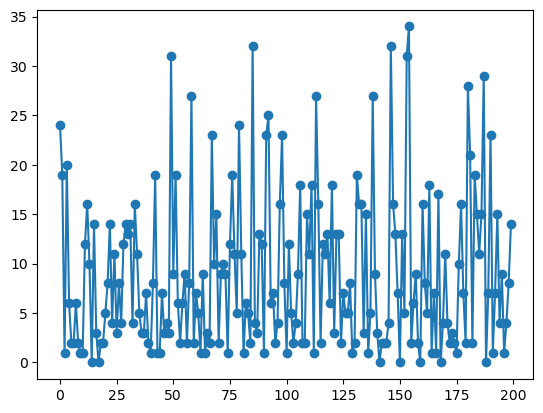

In [9]:
volume_data = list(time_bucket.values())
x = [i for i in range(len(volume_data))]

plt.plot(x, volume_data, marker='o', linestyle='-')
plt.show()

In [10]:
df_trade['revenue'] = df_trade['price'] * df_trade['quantity']
df_trade_sum = df_trade.groupby(['timestamp']).sum()
df_trade_sum = df_trade_sum.reset_index()
df_trade_sum

,timestamp,price,quantity,revenue
0,0,15008,15,75044
1,2,4997,2,9994
2,6,4999,5,24995
3,7,4997,2,9994
4,11,4998,6,29988
...,...,...,...,...
525,1990,4948,2,9896
526,1991,4948,1,4948
527,1992,4950,2,9900
528,1994,19804,7,34654


# RSI tunning

In [21]:
total_iter = 2000
bucket_size = 20
# bucket_size = 10
RSI_WINDOW = 10
MA_WINDOW = 5
MA_WINDOW_2 = 10
bucket_num = total_iter/bucket_size
time_bucket = {tuple(range(i, i+bucket_size)): {'volume': 0, 'revenue': 0} for i in range(0, 2000, bucket_size)}

for i in range(len(df_trade_sum)):
    timestamp = df_trade_sum.iloc[(i, 0)]
    volume = df_trade_sum.iloc[(i, 2)]
    revenue = df_trade_sum.iloc[(i, 3)]
    for key_tuple in time_bucket.keys():
        if timestamp in key_tuple:
            time_bucket[key_tuple]['volume'] += volume
            time_bucket[key_tuple]['revenue'] += revenue
            break

prev_avg = 0 
for k, v in time_bucket.items():
    volume = time_bucket[k]['volume']
    revenue = time_bucket[k]['revenue']
    time_bucket[k] = revenue/volume if volume != 0 else prev_avg
    prev_avg = time_bucket[k] if time_bucket[k] != 0 else prev_avg

In [22]:
price_agg_data = list(time_bucket.values())
price_percentage_diffs = [(price_agg_data[i] - price_agg_data[i-1])/price_agg_data[i-1] for i in range(1, len(price_agg_data))]
rsi_list = []
for i in range(len(price_percentage_diffs)-RSI_WINDOW+1):
    changes = [price_percentage_diffs[i] for i in range(i, i+RSI_WINDOW)]
    pos_change = [change for change in changes if change > 0]
    neg_change = [change for change in changes if change < 0]
    pos_avg = sum(pos_change)/len(pos_change)
    neg_avg = -sum(neg_change)/len(neg_change)
    rs = pos_avg/neg_avg
    rsi = 100 - (100 / (1+rs))
    rsi_list.append(rsi)

# Value error indicates the RSI window is too small.


In [23]:
ma_list = []
values = [value for value in time_bucket.values()]
for i in range(len(time_bucket)-MA_WINDOW+1):
    ma = sum(values[i:i+MA_WINDOW])/MA_WINDOW
    ma_list.append(ma)

In [24]:
ma_list_2 = []
values = [value for value in time_bucket.values()]
for i in range(len(time_bucket)-MA_WINDOW_2+1):
    ma = sum(values[i:i+MA_WINDOW_2])/MA_WINDOW_2
    ma_list_2.append(ma)

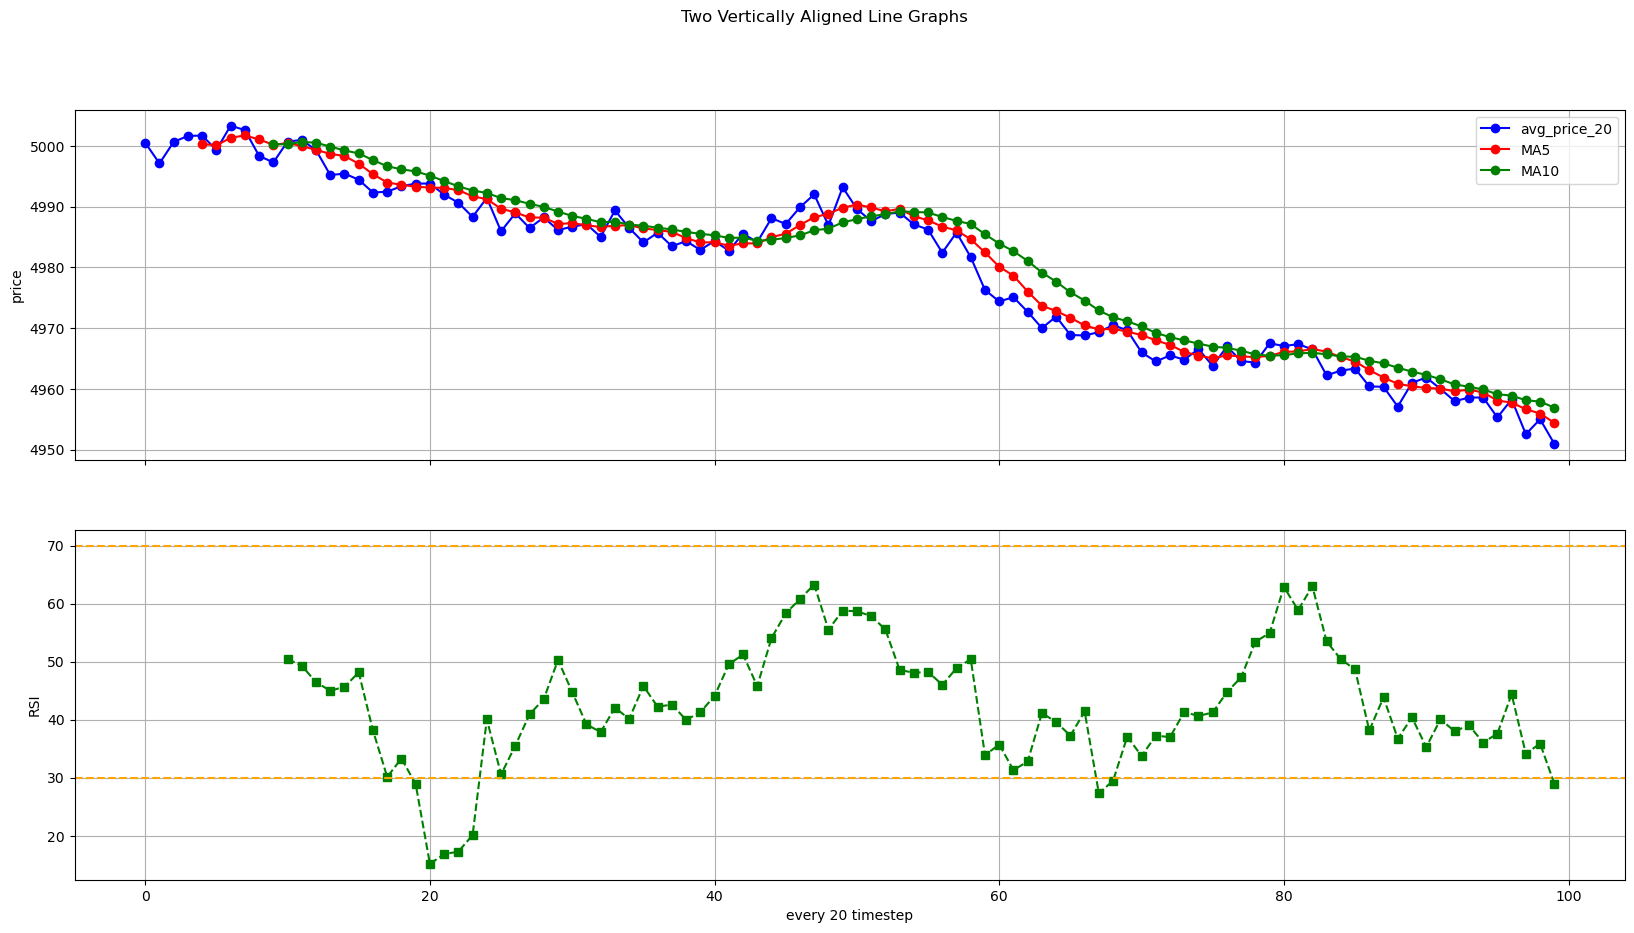

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)  # Two subplots, sharing the same x-axis
x_price = [i for i in range(len(price_agg_data))]

# Plot data1 on the first subplot
x_ma = [i for i in range(MA_WINDOW-1, len(price_agg_data))]
x_ma_2 = [i for i in range(MA_WINDOW_2-1, len(price_agg_data))]
ax1.plot(x_price, price_agg_data, marker='o', linestyle='-', color='blue', label=f'avg_price_{bucket_size}')
ax1.plot(x_ma, ma_list, marker='o', linestyle='-', color='red', label=f'MA{MA_WINDOW}')
ax1.plot(x_ma_2, ma_list_2, marker='o', linestyle='-', color='green', label=f'MA{MA_WINDOW_2}')
ax1.set_ylabel('price')
ax1.legend()
ax1.grid(True)

x_rsi = [i for i in range(RSI_WINDOW, len(price_agg_data))]
# Plot data2 on the second subplot
ax2.plot(x_rsi, rsi_list, marker='s', linestyle='--', color='green')
ax2.set_ylabel('RSI')
ax2.set_xlabel(f'every {bucket_size} timestep')  # Set x-axis label for the shared x-axis

ax2.axhline(y=70, color='orange', linestyle='--')
ax2.axhline(y=30, color='orange', linestyle='--')
ax2.grid(True)

# x_ma = [i for i in range(MA_WINDOW-1, len(price_agg_data))]
# ax3.plot(x_ma, ma_list, marker='s', linestyle='--', color='grey')
# ax3.set_ylabel('MA10')


# Add title to the entire figure
fig.suptitle('Two Vertically Aligned Line Graphs')

# Show plot
plt.show()